In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# Load your data
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_07_18_2024, 15_09_00_to_09_18_2024, 15_09_00.xlsx'
data = pd.read_excel(file_path, sheet_name='Data')

# Sort data by 'trip' and 'time'
data = data.sort_values(by=['trip', 'time']).reset_index(drop=True)


In [3]:
# Reset 'time' to start at 0 for each trip
data['time'] = data.groupby('trip')['time'].transform(lambda x: x - x.min())

In [4]:
# Filter out trips with fewer than 500 observations
data = data.groupby('trip').filter(lambda x: len(x) > 500)


In [5]:
features = ['time', 'Vehicle_Speed', 'Engine_speed']
target = 'Coolant_temperature'


In [6]:
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])


In [7]:
import joblib
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [8]:
window_size = 50  # Adjust as needed
stride = 5        # Overlap between windows


In [9]:
def create_sequences(data, features, target, window_size, stride):
    sequences = []
    targets = []
    initial_temps = []

    for trip_id, trip_data in data.groupby('trip'):
        trip_features = trip_data[features].values
        trip_targets = trip_data[target].values
        initial_temp = trip_data[target].iloc[0]  # Initial coolant temperature

        for i in range(0, len(trip_data) - window_size, stride):
            seq_x = trip_features[i:i+window_size]
            seq_y = trip_targets[i+window_size-1]  # Predict the last value in the window

            sequences.append(seq_x)
            targets.append(seq_y)
            initial_temps.append(initial_temp)

    return np.array(sequences), np.array(targets), np.array(initial_temps)


In [10]:
X, y, initial_temps = create_sequences(data, features, target, window_size, stride)
print(f"Generated {X.shape[0]} sequences.")


Generated 54089 sequences.


In [11]:
def augment_data(X, y, initial_temps, num_augments=5):
    augmented_X = []
    augmented_y = []
    augmented_initial_temps = []

    for i in range(len(X)):
        for _ in range(num_augments):
            noise = np.random.normal(0, 0.01, X[i].shape)
            X_noisy = X[i] + noise
            augmented_X.append(X_noisy)
            augmented_y.append(y[i])
            augmented_initial_temps.append(initial_temps[i])

    return np.array(augmented_X), np.array(augmented_y), np.array(augmented_initial_temps)


In [12]:
X_aug, y_aug, initial_temps_aug = augment_data(X, y, initial_temps)
print(f"After augmentation, total sequences: {X_aug.shape[0]}")


After augmentation, total sequences: 270445


In [13]:
X_train, X_test, y_train, y_test, initial_temps_train, initial_temps_test = train_test_split(
    X_aug, y_aug, initial_temps_aug, test_size=0.2, random_state=42
)


In [14]:
def build_model(window_size, feature_count):
    # CNN Input
    sequence_input = Input(shape=(window_size, feature_count), name='sequence_input')

    # Initial Temp Input
    initial_temp_input = Input(shape=(1,), name='initial_temp_input')

    # CNN Layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(sequence_input)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = Flatten()(x)

    # Concatenate initial_temp
    x = Concatenate()([x, initial_temp_input])

    # Fully Connected Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)

    model = Model(inputs=[sequence_input, initial_temp_input], outputs=output)
    return model


In [15]:
feature_count = len(features)
model = build_model(window_size, feature_count)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 50, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 48, 64)         │            640 │ sequence_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 46, 32)         │          6,176 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1472)           │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_temp_input        │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1473)           │              0 │ flatten[0][0],         │
│                           │                        │                │ initial_temp_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         94,336 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,217 (395.38 KB)

 Trainable params: 101,217 (395.38 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Prepare inputs for training and testing
X_train_seq = X_train
X_test_seq = X_test

X_train_initial = initial_temps_train.reshape(-1, 1)
X_test_initial = initial_temps_test.reshape(-1, 1)


In [18]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_model.keras', save_best_only=True)
]


In [19]:
history = model.fit(
    [X_train_seq, X_train_initial], y_train,
    validation_data=([X_test_seq, X_test_initial], y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 272.6608 - mae: 10.7114 - val_loss: 28.9393 - val_mae: 3.5964
Epoch 2/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 92.1896 - mae: 7.4101 - val_loss: 34.4386 - val_mae: 3.6295
Epoch 3/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 79.1848 - mae: 6.9361 - val_loss: 17.1813 - val_mae: 2.6663
Epoch 4/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 72.3098 - mae: 6.6538 - val_loss: 22.5298 - val_mae: 3.5288
Epoch 5/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 67.9700 - mae: 6.4429 - val_loss: 17.0234 - val_mae: 2.7525
Epoch 6/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 64.8118 - mae: 6.2885 - val_loss: 14.8223 - val_mae: 2.5640
Epoch 7/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 61.3537 - mae: 6.1077 - val_loss: 16.9972 - val_mae: 2.8205
Epoch 8/50
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 58.0135 - mae: 5.9433 - val_loss: 18.2329 - val_mae: 2.8928
Epoch 9/50
676

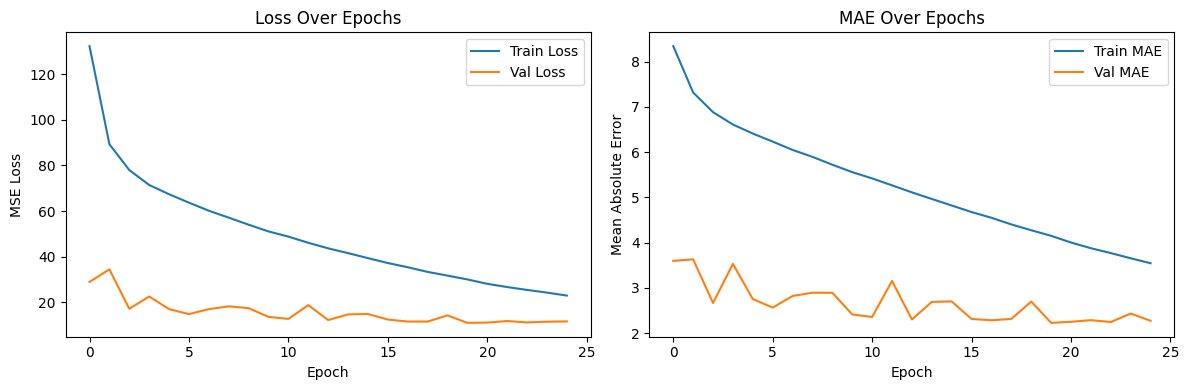

In [20]:
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
test_loss, test_mae = model.evaluate([X_test_seq, X_test_initial], y_test)
print(f"Test MSE Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.9068 - mae: 2.2138
Test MSE Loss: 10.9761
Test MAE: 2.2260


In [22]:
y_pred = model.predict([X_test_seq, X_test_initial])


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


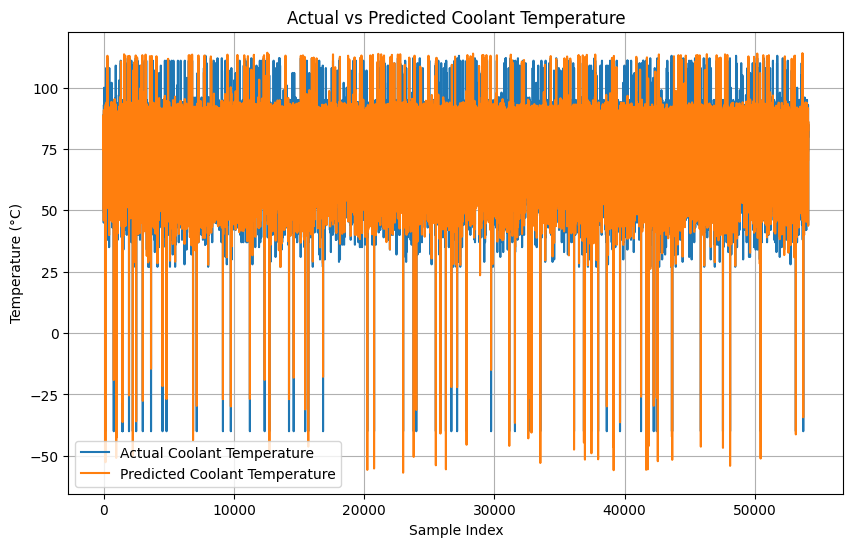

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Coolant Temperature')
plt.plot(y_pred, label='Predicted Coolant Temperature')
plt.title('Actual vs Predicted Coolant Temperature')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
model.save('cnn_coolant_temperature_model.keras')


# Predict NEDC

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


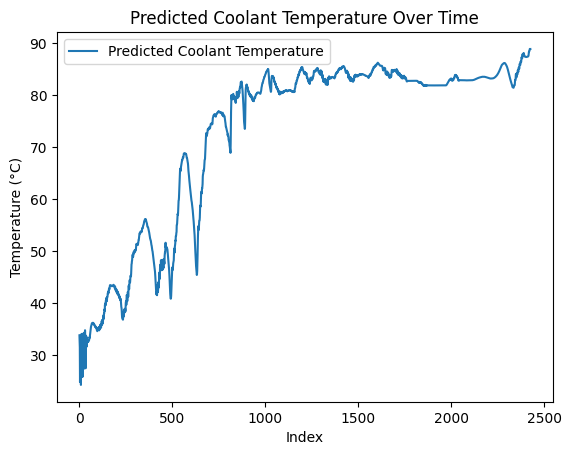

In [34]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('cnn_coolant_temperature_model.keras')

# Load the scaler
scaler = joblib.load('scaler.joblib')

# Prepare new data (assuming 'new_trip_data' is a DataFrame)
def prepare_new_data(new_trip_data, window_size):
    # Scale features
    new_trip_data[features] = scaler.transform(new_trip_data[features])

    # Create sequences
    X_new_seq = []
    initial_temps_new = []

    trip_features = new_trip_data[features].values
    initial_temp = 24  # Or use provided initial_temp

    for i in range(len(new_trip_data) - window_size):
        seq_x = trip_features[i:i+window_size]
        X_new_seq.append(seq_x)
        initial_temps_new.append(initial_temp)

    return np.array(X_new_seq), np.array(initial_temps_new).reshape(-1, 1)

# Example usage
new_trip_data = pd.read_csv('/content/Interpolated_Data__2Hz_.csv')
X_new_seq, initial_temps_new = prepare_new_data(new_trip_data, window_size)
y_new_pred = model.predict([X_new_seq, initial_temps_new])

plt.plot(y_new_pred, label='Predicted Coolant Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Predicted Coolant Temperature Over Time')
plt.legend()
plt.show()


# Predict New Files

Processing Trips:   0%|          | 0/3 [00:00<?, ?it/s]

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


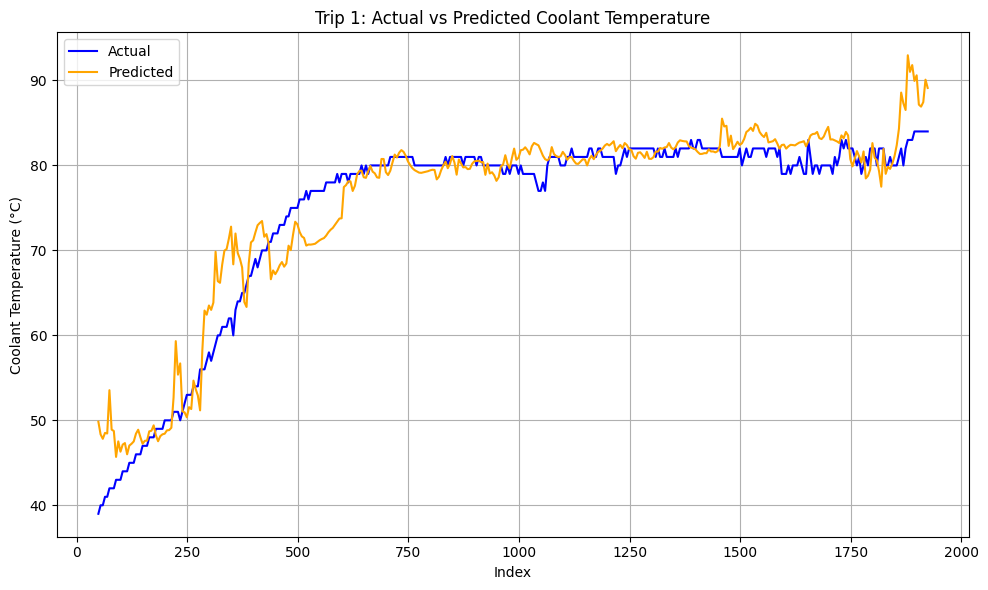

Processing Trips:  33%|███▎      | 1/3 [00:01<00:03,  1.83s/it]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


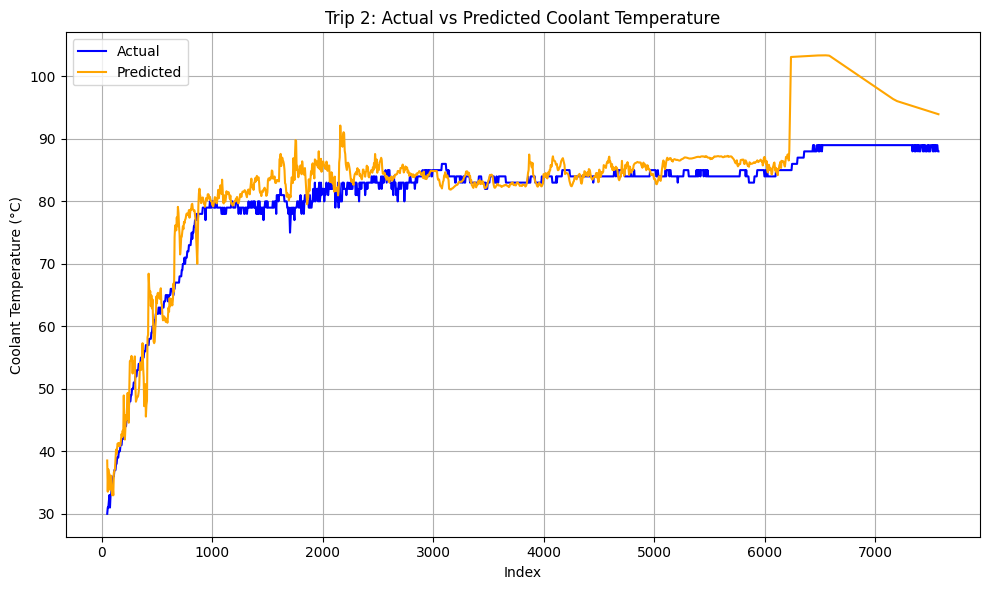

Processing Trips:  67%|██████▋   | 2/3 [00:03<00:01,  1.47s/it]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


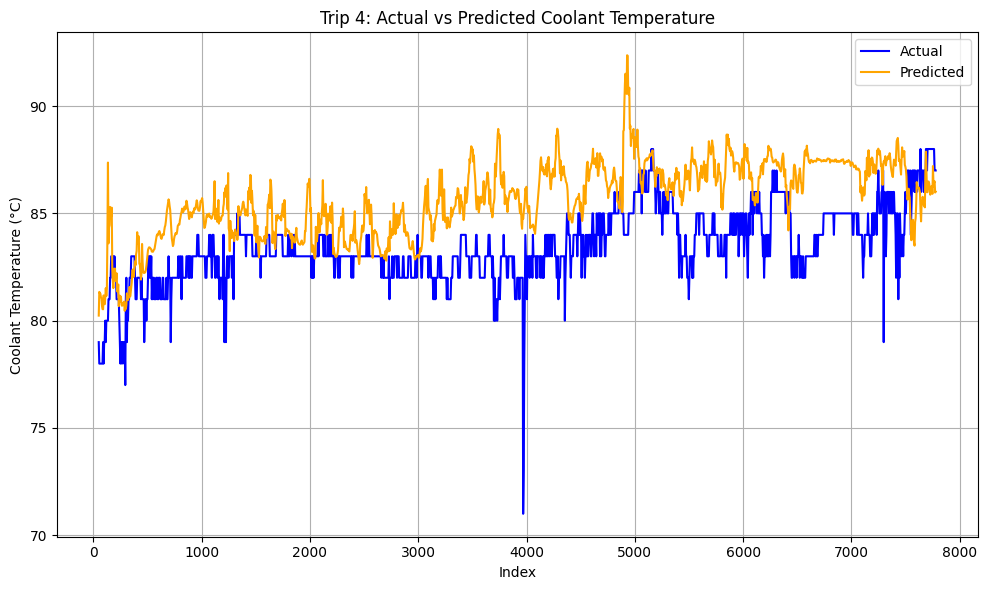

Processing Trips: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

All trip predictions have been saved to trip_predictions.xlsx


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm  # For progress bar

# Ensure you have tqdm installed. If not, uncomment the following line:
# !pip install tqdm

# Load the trained model
model = load_model('cnn_coolant_temperature_model.keras')

# Load the scaler
scaler = joblib.load('scaler.joblib')

# Reload the original data
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_09_19_2024, 10_36_00_to_09_22_2024, 10_36_00.xlsx'
data = pd.read_excel(file_path, sheet_name='Data')

# Sort data by 'trip' and 'time'
data = data.sort_values(by=['trip', 'time']).reset_index(drop=True)

# Reset 'time' to start at 0 for each trip
data['time'] = data.groupby('trip')['time'].transform(lambda x: x - x.min())

# Filter out trips with fewer than 500 observations
filtered_data = data.groupby('trip').filter(lambda x: len(x) > 500)

features = ['time', 'Vehicle_Speed', 'Engine_speed']
target = 'Coolant_temperature'

window_size = 50  # Must match the window_size used during training
stride = 5        # Must match the stride used during training

def create_sequences_trip(trip_data, features, window_size, stride):
    """
    Creates sequences for a single trip.

    Returns:
        sequences (np.ndarray): Array of shape (num_sequences, window_size, num_features)
        indices (list): List of indices corresponding to each sequence's prediction point
    """
    trip_features = trip_data[features].values
    sequences = []
    indices = []
    for i in range(0, len(trip_data) - window_size, stride):
        seq_x = trip_features[i:i+window_size]
        sequences.append(seq_x)
        indices.append(i + window_size - 1)  # Prediction is for the last point in the window
    return np.array(sequences), indices

# Prepare Excel writer
output_file = 'trip_predictions.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Iterate over each trip
    for trip_id, trip_data in tqdm(filtered_data.groupby('trip'), desc='Processing Trips'):
        # Scale the features
        trip_features_scaled = scaler.transform(trip_data[features])
        trip_data_scaled = trip_data.copy()
        trip_data_scaled[features] = trip_features_scaled

        # Create sequences
        X_trip, indices = create_sequences_trip(trip_data_scaled, features, window_size, stride)

        if len(X_trip) == 0:
            print(f"Trip {trip_id} skipped due to insufficient data after sequencing.")
            continue

        # Prepare initial_temp_input (constant for the trip)
        initial_temp = trip_data_scaled[target].iloc[0]
        X_trip_initial = np.full((X_trip.shape[0], 1), initial_temp)

        # Predict
        y_pred = model.predict([X_trip, X_trip_initial]).flatten()

        # Actual values
        y_actual = trip_data[target].values[indices]

        # Create DataFrame for this trip
        df_trip = pd.DataFrame({
            'Index': indices,
            'Actual_Coolant_Temperature': y_actual,
            'Predicted_Coolant_Temperature': y_pred
        })

        # Save to Excel sheet (sheet names have a maximum length of 31 characters)
        sheet_name = f'Trip_{trip_id}'[:31]  # Truncate if necessary
        df_trip.to_excel(writer, sheet_name=sheet_name, index=False)

        # Plot Actual vs Predicted
        plt.figure(figsize=(10, 6))
        plt.plot(df_trip['Index'], df_trip['Actual_Coolant_Temperature'], label='Actual', color='blue')
        plt.plot(df_trip['Index'], df_trip['Predicted_Coolant_Temperature'], label='Predicted', color='orange')
        plt.title(f'Trip {trip_id}: Actual vs Predicted Coolant Temperature')
        plt.xlabel('Index')
        plt.ylabel('Coolant Temperature (°C)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print(f"All trip predictions have been saved to {output_file}")
